In [1]:
import pandas as pd
import numpy as np
import sys
from math import sqrt 
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn import cross_validation
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error,mean_absolute_error
from scipy.sparse.linalg import svds
from surprise import SVD,KNNBasic
from surprise.dataset import Reader
from surprise import Dataset as ds
from surprise import evaluate, print_perf


C:\Users\akwes\Anaconda2\envs\ML\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
C:\Users\akwes\Anaconda2\envs\ML\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
print (sys.version)

3.6.0 |Continuum Analytics, Inc.| (default, Dec 23 2016, 11:57:41) [MSC v.1900 64 bit (AMD64)]


# Introduction

This is a case study in recommender systems, specifically collaborative filtering. We will use two different mehtods for collaborative filtering and present it as business project.



# Dataset
The dataset we are using is the [book-crossings](http://www2.informatik.uni-freiburg.de/~cziegler/BX/) dataset. It's a collection of ratings scrapped from the book-crossings website. The ratings are in the 1-10 range with 0 for implicit ratings.
The book crossings website tracks books that are freely shared through swapping. Due to this the dataset skews towards obscure titles with cult followings. 


In [3]:
dataset_raw =pd.read_csv("BX-Book-Ratings.csv",delimiter=";",encoding="latin_1")

In [4]:
#Let's take a look at what the data looks like 
dataset_raw.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [5]:
#nobody likes duplicates
dataset_raw.duplicated(["User-ID","ISBN"]).any()

False

The very first thing is that we want to use explicit ratings so let's remove anything less than 1

In [6]:
dataset=dataset_raw[dataset_raw["Book-Rating"]>=1]

In [7]:
#Let's take a look at some summary statistics
unique_users = len(dataset["User-ID"].unique())
print ("The number of unique users is {:,}".format(unique_users))
unique_movies = len(dataset["ISBN"].unique())
print ("The number of unique books is {:,}".format(unique_movies))
ratings = dataset.shape[0]
print ("The number of ratings is {:,}".format(ratings))

The number of unique users is 77,805
The number of unique books is 185,973
The number of ratings is 433,671


In [8]:
#It's quite likely only some very "popular" books have many ratings, and most users haven't rated many books
book_counts = dataset.groupby(["ISBN"]).count()
display(book_counts["Book-Rating"].describe())

user_counts = dataset.groupby(["User-ID"]).count()
display(user_counts["Book-Rating"].describe())

count    185973.000000
mean          2.331903
std           6.834667
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         707.000000
Name: Book-Rating, dtype: float64

count    77805.000000
mean         5.573819
std         44.001879
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       8524.000000
Name: Book-Rating, dtype: float64

The average number of ratings per book is only 2.33, and even worse the 75th percentile is only 2 ratings.  
Regarding users, the 75th percentile is only 3 ratings. All around a rather sparse dataset.

In both cases the distributions are heavily skewed by some extremely "popular" books and active users.  

We can probably cut off a large number of both users and books which have little interaction. This will affect our coverage though. Another reason to cut off a lot of data is that memory based models are resource intensive and wont work on large datasets.



In [9]:
#plot distribution of ratings
#plot ratings per user 

In [10]:
print (book_counts['Book-Rating'].quantile(np.arange(.75, 1, .01)))

0.75     2.0
0.76     2.0
0.77     2.0
0.78     2.0
0.79     2.0
0.80     2.0
0.81     2.0
0.82     2.0
0.83     2.0
0.84     3.0
0.85     3.0
0.86     3.0
0.87     3.0
0.88     3.0
0.89     3.0
0.90     4.0
0.91     4.0
0.92     4.0
0.93     5.0
0.94     6.0
0.95     6.0
0.96     8.0
0.97    10.0
0.98    13.0
0.99    22.0
Name: Book-Rating, dtype: float64


In [11]:
print (user_counts['Book-Rating'].quantile(np.arange(.75, 1, .01)))

0.75     3.0
0.76     3.0
0.77     3.0
0.78     4.0
0.79     4.0
0.80     4.0
0.81     4.0
0.82     5.0
0.83     5.0
0.84     5.0
0.85     6.0
0.86     6.0
0.87     7.0
0.88     7.0
0.89     8.0
0.90     9.0
0.91    10.0
0.92    11.0
0.93    13.0
0.94    16.0
0.95    19.0
0.96    23.0
0.97    30.0
0.98    44.0
0.99    73.0
Name: Book-Rating, dtype: float64


In [12]:
#Can we get some idea of what the most frequently rated books are?
#Can we see what the most positively rated book is 

#Load the book descriptions 
descriptions_dataset =pd.read_csv("BX-Books.csv",delimiter=";",encoding='latin_1',escapechar="\\")

#join descriptions to the books
merged=pd.merge(dataset,descriptions_dataset,how="inner",on="ISBN")


In [13]:
num_rated=merged.groupby(["ISBN","Book-Title"]).count()
num_rated.sort_values("Book-Rating",ascending=False)[["Book-Rating"]].head(10)


,,Book-Rating
ISBN,Book-Title,
0316666343,The Lovely Bones: A Novel,707
0971880107,Wild Animus,581
0385504209,The Da Vinci Code,487
0312195516,The Red Tent (Bestselling Backlist),383
0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,320
059035342X,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),313
0142001740,The Secret Life of Bees,307
0446672211,Where the Heart Is (Oprah's Book Club (Paperback)),295
044023722X,A Painted House,281


In [14]:
avg_rating=merged.groupby(["ISBN","Book-Title"]).mean()
avg_rating.sort_values("Book-Rating",ascending=False)[["Book-Rating"]].head(10)

,,Book-Rating
ISBN,Book-Title,
034017420X,Seven Men of Gascony Rfd Hpb,10.0
0821414534,"Ohio Is My Dwelling Place: Schoolgirl Embroideries, 1803-1850",10.0
0821225987,Physiognomy : The Mark Seliger Photographs,10.0
0821226665,White on White : Creating Elegant Rooms with Classic Whites,10.0
0821226703,Air and Space : The National Air and Space Museum Story of Flight,10.0
0821226770,Pope John Paul II : A Tribute,10.0
0821227718,Life: World War 2: History's Greatest Conflict in Pictures,10.0
0821227947,The Breathing Field: Meditations on Yoga,10.0
0821228188,"Wise Women : A Celebration of Their Insights, Courage, and Beauty",10.0


In [15]:
combined_rating = num_rated.join(avg_rating,lsuffix="L",rsuffix="")

In [16]:
combined_rating.head()

#highest rated books and the number of times rated
t1=combined_rating.sort_values("Book-Rating",ascending=False)[["Book-RatingL","Book-Rating"]].head(10)
t1.columns=["count","avg_rating"]
display(t1)

#most rated books and the average rating
t2=combined_rating.sort_values("Book-RatingL",ascending=False)[["Book-RatingL","Book-Rating"]].head(10)
t2.columns=["count","avg_rating"]
display(t2)


,,count,avg_rating
ISBN,Book-Title,,
034017420X,Seven Men of Gascony Rfd Hpb,1,10.0
0821414534,"Ohio Is My Dwelling Place: Schoolgirl Embroideries, 1803-1850",1,10.0
0821225987,Physiognomy : The Mark Seliger Photographs,2,10.0
0821226665,White on White : Creating Elegant Rooms with Classic Whites,1,10.0
0821226703,Air and Space : The National Air and Space Museum Story of Flight,1,10.0
0821226770,Pope John Paul II : A Tribute,1,10.0
0821227718,Life: World War 2: History's Greatest Conflict in Pictures,1,10.0
0821227947,The Breathing Field: Meditations on Yoga,1,10.0
0821228188,"Wise Women : A Celebration of Their Insights, Courage, and Beauty",2,10.0


,,count,avg_rating
ISBN,Book-Title,,
0316666343,The Lovely Bones: A Novel,707,8.185290
0971880107,Wild Animus,581,4.390706
0385504209,The Da Vinci Code,487,8.435318
0312195516,The Red Tent (Bestselling Backlist),383,8.182768
0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,320,7.887500
059035342X,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),313,8.939297
0142001740,The Secret Life of Bees,307,8.452769
0446672211,Where the Heart Is (Oprah's Book Club (Paperback)),295,8.142373
044023722X,A Painted House,281,7.338078


# Plan

Our objective here is to make recommendations of books based on a user's already rated books.
From a business perspective we are assuming we're in the business of selling books and are trying to recommend books in our catalogue that a user would want to buy based on their previously read books. Our measures of success will be the accuracy of our recommendations and the coverage of the catalogue. We're trying to optimize our accuracy to achieve better results than a baseline system that only predicts based on the average user and item ratings. We're limiting our dataset to the most shared books so we are definitely missing out on making serendipitous predictions and will not achieve 100% coverage. Our current plan is not well optimized for users who have no ratings. Since we are filling in a complete ratings matrix for each algorithm our coverage score will not change between algorithms. The last downside is that adding new users or books means recalculating our entire ratings matrix. Our man evaluation metric will be the RMSE calculated on a held out test set

## Methods

We will implement two recommendation systems
* User based collaborative filtering 
* Low rank Matrix Factorization 


# Pre-process
We'll perform the following preprocessing steps.
1. To start with we restrict ourselves to around the top .001 percent of the most shared books.
2. We'll also restrict rouselves to users that have at least 2 ratings
3. To make working with the data easier we will reindex the users and items from 1-n and 1-m.
For this first attempt we will drastically reduce the size of the dataset as it is meant to be an epxloratory task.
Part of the rationale for trimming the dataset is that we get more accurate results by predicting the most active users and books. In addition collaborative filtering does not scale well with large datasets 
4. Instead of filling the missing values with 0 before running our algorithm, we will fill them with the average rating for each book.



In [17]:
#1.
top_5_index = book_counts[book_counts["Book-Rating"]>book_counts["Book-Rating"].quantile(.999)].index
top_5 = merged[merged["ISBN"].isin(top_5_index)]


#2.
users_group = top_5.groupby(["User-ID"]).count()["Book-Rating"]>=2
users_index = (users_group[users_group]).index

users = top_5[top_5["User-ID"].isin(users_index)]

temp=users

#temp_group = users.groupby(["ISBN"]).count()["Book-Rating"]>=2
#temp = temp[temp["ISBN"].isin(temp_group[temp_group].index)]
#finally each book must have at least 2 ratings

#temp = top_5

In [18]:
only_one=temp.groupby(["ISBN"]).count()["Book-Rating"]==1
len(only_one[only_one])

0

Every Book has more than one rating

In [19]:
N = temp["User-ID"].unique()
print ("The number of unique users in the trimmed dataset is {:,}".format(len(N)))
M = temp["ISBN"].unique()
print ("The number of unique books in the trimmed dataset is {:,}".format(len(M)))
print ("The number of ratings in the trimmed dataset is {:,}".format(temp.shape[0]))

The number of unique users in the trimmed dataset is 4,328
The number of unique books in the trimmed dataset is 178
The number of ratings in the trimmed dataset is 17,195


In [20]:
#4. take unique users make a dataframe, take unique isbn make a dataframe 
#reset index on the frames to get the indexes as a column 
#join the dataset on both of these new frames
uid = pd.DataFrame(N)
uid = uid.reset_index()
uid.columns=["uid", "User-ID"]
bid = pd.DataFrame(M)
bid = bid.reset_index()
bid.columns=["bid","ISBN"]

In [21]:
t1 = temp.merge(uid,how="left",on=["User-ID"])
t2 = t1.merge(bid,how="left",on=["ISBN"])

data = t2

train_data, test_data = cross_validation.train_test_split(data, test_size=.20)

In [22]:
print (train_data.shape)
print (test_data.shape)

(13756, 12)
(3439, 12)


In [23]:
#Now we construct a ratings matrix R 
#We also build a matrix of only test samples

R_temp= data.pivot(index="uid",columns="bid",values="Book-Rating")
test_matrix = np.zeros((len(N),len(M)))


for row in test_data.itertuples():
    user = row.uid
    book = row.bid
    value = row[3]
    R_temp.ix[user][book]=np.nan
    test_matrix[user][book]=value
    
    
#we then fill in the unknown values with the average rating for each book
#because we removed some ratings for the test set there may be books that have no ratings 
#we will give these an arbitratry rating of 0 since we can't compute an average for them
R=R_temp.fillna(R_temp.mean().fillna(0))

In [24]:
#scoring mehtods

#we assume the testset is a rankings matrix with values for the entries we want to test, zero everywhere else
def rmse_score(prediction,testset):
    preds = prediction[testset.nonzero()].flatten()
    true = testset[testset.nonzero()].flatten()
    mse = mean_squared_error(true,preds)
    return sqrt(mse)

def mae_score(prediction,testset):
    preds = prediction[testset.nonzero()].flatten()
    true = testset[testset.nonzero()].flatten()
    return mean_absolute_error(true,preds)

# Baseline 

We calculate a naive baseline to compare our algorithm results to.  
The baseline is essentially an "average" rating based on the average book rating + user baseline predictor + item baseline predictor.  
It's taken from:

Michael D. Ekstrand, John T. Riedl and Joseph A. Konstan (2011), "Collaborative Filtering Recommender Systems", Foundations and Trends® in Human–Computer Interaction: Vol. 4: No. 2, pp 81-173. http://dx.doi.org/10.1561/1100000009


In [25]:
#overall average + user baseline + item baseline

avg =train_data["Book-Rating"].mean()


#if there are users in the training set with no ratings fill them with zero
bu = np.nan_to_num(np.nanmean(R_temp-avg,axis =1,keepdims=True))
bu = np.repeat(bu,R_temp.shape[1],axis=1)

#If there are books in the train set with no ratings fill them with zero
bi = np.nan_to_num(np.nanmean(R_temp-avg- bu, axis=0,keepdims=True))
bi = np.repeat(bi,R_temp.shape[0],axis=0)


baseline = avg+bu+bi

baseline_train_rmse = rmse_score(baseline,R_temp.fillna(0).as_matrix())
baseline_test_rmse = rmse_score(baseline,test_matrix)
print ("RMSE for the baseline test set is {:f}".format(baseline_test_rmse))
print ("RMSE for the baseline train set is {:f}".format(baseline_train_rmse))



RMSE for the baseline test set is 1.826440
RMSE for the baseline train set is 1.227337


C:\Users\akwes\Anaconda2\envs\ML\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: Mean of empty slice


# Algorithm 1

## User based collaborative filtering 

In [26]:
def predict(similarity_matrix,ratings):
    avg_user = ratings.mean(axis=1).values.reshape(ratings.shape[0],1)
    centered = np.subtract(ratings,avg_user)
    temp1 = similarity_matrix.dot(centered)
    #todo see what happens when we remove 1
    temp2 = np.sum(np.abs(similarity_matrix),axis=1,keepdims=True)
    return np.divide(temp1,temp2) + avg_user


def evaluate_user_based(train,test,complete,metric,fold=1,debug=False):
    r_temp= complete.pivot(index="uid",columns="bid",values="Book-Rating")
    t_matrix = np.zeros(r_temp.shape)
    for row in test.itertuples():
        user = row.uid
        book = row.bid
        value = row[3]
        r_temp.ix[user][book]=np.nan
        t_matrix[user][book]=value
    
    r=r_temp.fillna(r_temp.mean().fillna(0))
    u_sim = pairwise_distances(r,metric=metric)
    u_pred = predict(u_sim,r)
    test_rmse = rmse_score(u_pred,t_matrix)
    train_rmse = rmse_score(u_pred,r_temp.fillna(0).as_matrix())
    if(debug):
        print ("RMSE for the test set for {} for fold {} is {:f}".format(metric,fold,test_rmse))
        print ("RMSE for the train set for {} for fold {} is is {:f}".format(metric,fold,train_rmse))
    return train_rmse,test_rmse
    
    
def evaluate_model_based(train,test,complete,k,fold=1,debug=False):
    r_temp= complete.pivot(index="uid",columns="bid",values="Book-Rating")
    t_matrix = np.zeros(r_temp.shape)
    for row in test.itertuples():
        user = row.uid
        book = row.bid
        value = row[3]
        r_temp.ix[user][book]=np.nan
        t_matrix[user][book]=value
        
    r=r_temp.fillna(r_temp.mean().fillna(0))
    u, s, vT = svds(r, k = k)

    s_diag=np.diag(s)
    m_pred = np.dot(np.dot(u, s_diag), vT)

    test_rmse = rmse_score(m_pred,t_matrix)
    train_rmse = rmse_score(m_pred,r_temp.fillna(0).as_matrix())
    if(debug):
        print ("RMSE for the test set for k={} for fold {} is {:f}".format(k,fold,test_rmse))
        print ("RMSE for the train set for k={} for fold {} is is {:f}".format(k,fold,train_rmse))
    return train_rmse,test_rmse
    
    

In [27]:
user_similarity = pairwise_distances(R,metric="correlation")

user_predictions = predict(user_similarity,R)

user_test_rmse = rmse_score(user_predictions,test_matrix)

#evaluate on the training set using only the provided ratings
user_train_rmse = rmse_score(user_predictions,R_temp.fillna(0).as_matrix())


print ("RMSE for the test set is {:f}".format(user_test_rmse))
print ("RMSE for the train set is {:f}".format(user_train_rmse))

RMSE for the test set is 1.653727
RMSE for the train set is 1.651184


In [28]:
evaluate_user_based(train_data,test_data,data,"correlation",1,True)

RMSE for the test set for correlation for fold 1 is 1.653727
RMSE for the train set for correlation for fold 1 is is 1.651184


(1.6511838276633186, 1.6537269421148284)

# Algorithm 2

## Matrix Facorization

In [29]:
#We can re-use the training and test splits from before

U, S, VT = svds(R, k = 6)

S_diag=np.diag(S)
model_predictions = np.dot(np.dot(U, S_diag), VT)

model_test_rmse = rmse_score(model_predictions,test_matrix)
model_train_rmse = rmse_score(model_predictions,R_temp.fillna(0).as_matrix())



print ("RMSE for the test set is {:f}".format(model_test_rmse))
print ("RMSE for the train set is {:f}".format(model_train_rmse))

RMSE for the test set is 1.654593
RMSE for the train set is 1.553805


In [30]:
evaluate_model_based(train_data,test_data,data,6,1,True)

RMSE for the test set for k=6 for fold 1 is 1.654593
RMSE for the train set for k=6 for fold 1 is is 1.553805


(1.553805175471709, 1.6545934102245758)

# Evaluation

We can now take a look at out preliminary results

We have a baseline, a User-based approach, and a model based approach using Matrix Factorization.

We want to compare the RMSE for each of these models evaluated on the test set.


In [31]:
pd.DataFrame({"Baseline":[baseline_train_rmse,baseline_test_rmse],"User-based":[user_train_rmse,user_test_rmse],"Model-based":[model_train_rmse,model_test_rmse]},index=["train","test"])

,Baseline,Model-based,User-based
train,1.227337,1.553805,1.651184
test,1.826440,1.654593,1.653727


From the preliminary results we see that our algorithms perform slightly better than the baseline.   

We also see that the rmse on the training set for the model based approach is slightly lower than the test, this tells us that the model based approach is overfitting to the training set and would benefit from regularization in future runs.



## Hyperparameters
Now that we have the basic functionality we want to tune some of the parameters of the different algorithms
* For the User-based approach we want to try different distance measures
* For the Model-based appriach we want to try different sizes of k, the latent factor rank

We will also used 5 fold cross validation to get a more stable result.


In [32]:
def foldit(splits_num,dataset,ks):
    kf = KFold(n_splits = splits_num,shuffle=True)
    #make possible k values a proportion of the number of users
    distance_metrics = ["euclidean","correlation","cosine"]


    model_based_results={}
    user_based_results={}
    for m in distance_metrics:
        user_based_results[m]={"train":[],"test":[]}

    for k_val in ks:
        model_based_results[k_val]={"train":[],"test":[]}


    i=1
    splits = kf.split(dataset)
    for train_index,test_index in splits:
        train_set = data.ix[train_index]
        test_set = data.ix[test_index]
        for m in distance_metrics:
            tr,te = evaluate_user_based(train_set,test_set,data,m,i)
            user_based_results[m]["train"].append(tr)
            user_based_results[m]["test"].append(te)
        for k_val in ks:
            tr,te = evaluate_model_based(train_set,test_set,data,k_val,i)
            model_based_results[k_val]["train"].append(tr)
            model_based_results[k_val]["test"].append(te)
        print ("fold {} of {} complete".format(i,splits_num))
        i+=1
    return user_based_results,model_based_results
    

    
    
    

In [33]:
n = min(len(data["User-ID"].unique()),len(data["ISBN"].unique()))
step = int((n/1.1-n/9)/10)
ks = np.arange(int(n/9),int(n/1.1),step)[:-1]
user_results,model_results = foldit(5,data,ks)

fold 1 of 5 complete
fold 2 of 5 complete
fold 3 of 5 complete
fold 4 of 5 complete
fold 5 of 5 complete


In [34]:
frame_data={}
for m in user_results:
    fold_results = user_results[m]
    tr_avg = np.average(fold_results["train"])
    te_avg = np.average(fold_results["test"])
    frame_data[m]=[tr_avg,te_avg]
    
pd.DataFrame(frame_data,index=["train","test"])

,correlation,cosine,euclidean
train,1.647582,1.647812,1.642828
test,1.668264,1.668294,1.668262


In [35]:
frame_data={}
for k in model_results:
    fold_results = model_results[k]
    tr_avg = np.average(fold_results["train"])
    te_avg = np.average(fold_results["test"])
    frame_data[k]=[tr_avg,te_avg]
temp_frame=pd.DataFrame(frame_data,index=["train","test"])
display(temp_frame)

,19,33,47,61,75,89,103,117,131,145
train,1.361947,1.203089,1.065694,0.943989,0.829975,0.721211,0.616274,0.520522,0.428841,0.334278
test,1.662495,1.659671,1.658128,1.658875,1.660895,1.662987,1.665096,1.667157,1.669213,1.671588


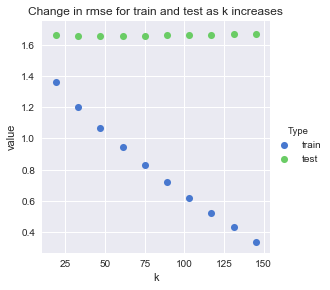

In [36]:
t2=temp_frame.reset_index()
t3=pd.melt(t2,id_vars=["index"],value_vars=list(t2.columns[1:]))
t3.columns=["Type","k","value"]

sns.lmplot(x="k", y="value", hue="Type", data=t3,
            ci=None, palette="muted",size=4,
           scatter_kws={"s": 50, "alpha": 1},fit_reg=False)
plt.title("Change in rmse for train and test as k increases")
plt.show()

It appears there is little difference between the different distance metrics in terms of the rmse on the test.  

For the Model-based approach it appears the optimal k is around 274, as the test set rmse begins to increase at that point. Even that increase is not very significant. 

Finally we try a third party library instead of our native implementations.  
This is using the [surprise](http://surprise.readthedocs.io/en/latest/index.html) library and is an SVD model

In [37]:
def tp(d):
    reader = Reader(rating_scale=(1, 10))

    third_data = ds.load_from_df(data[['User-ID', 'ISBN', 'Book-Rating']], reader)

    third_data.split(n_folds=5)
    algo = SVD()

    perf = evaluate(algo,third_data,measures=["RMSE"],verbose=0)
    
    return np.average(perf["RMSE"])

In [38]:
print ("test set rmse for svd is {}".format(tp(data)))

test set rmse for svd is 1.6169145545962729


The third party library achieves even better results for the svd than our implementation.  

## Sample size

We now want to observe how our results change as we reduce the number of users.  
Our original evaluation used users with 3 or more ratings, which gave us 1,372 users.  
We will now take a look at the upper percentiles for user counts to vary our user size.

In [39]:
tiles=top_5.groupby(["User-ID"]).count()['Book-Rating'].quantile(np.arange(.97, 1, .001))
print (tiles)

0.970      8.0
0.971      8.0
0.972      8.0
0.973      8.0
0.974      8.0
0.975      8.0
0.976      9.0
0.977      9.0
0.978      9.0
0.979      9.0
0.980      9.0
0.981      9.0
0.982     10.0
0.983     10.0
0.984     10.0
0.985     10.0
0.986     11.0
0.987     11.0
0.988     11.0
0.989     12.0
0.990     12.0
0.991     13.0
0.992     13.0
0.993     14.0
0.994     14.0
0.995     15.0
0.996     16.0
0.997     17.0
0.998     21.0
0.999     25.0
1.000    120.0
Name: Book-Rating, dtype: float64


In [40]:
#take 11 evenly spaced valus and throw out the last one
percentiles =tiles.values[0::3][:-1]
print (percentiles)

[  8.   8.   9.   9.  10.  10.  11.  13.  14.  17.]


In [41]:
sample ={}
i=1
for p in percentiles:
    users_grouping = top_5.groupby(["User-ID"]).count()["Book-Rating"]>=p
    users_indexes = (users_grouping[users_grouping]).index
    users_trimmed = top_5[top_5["User-ID"].isin(users_indexes)]
    n_users = len(users_trimmed["User-ID"].unique())
    sample[n_users]={}
    lcd= min(len(users_trimmed["User-ID"].unique()),len(users_trimmed["ISBN"].unique()))
    k= int(.20*lcd)
    user_results,model_results = foldit(5,users_trimmed,[k])
    third_party_results = tp(users_trimmed)
    sample[n_users]["u"]=user_results
    sample[n_users]["m"]=model_results
    sample[n_users]["t"]=third_party_results
    print ("{} of {} sample sizes run".format(i,len(percentiles)))
    i+=1
    
    

fold 1 of 5 complete
fold 2 of 5 complete
fold 3 of 5 complete
fold 4 of 5 complete
fold 5 of 5 complete
1 of 10 sample sizes run
fold 1 of 5 complete
fold 2 of 5 complete
fold 3 of 5 complete
fold 4 of 5 complete
fold 5 of 5 complete
2 of 10 sample sizes run
fold 1 of 5 complete
fold 2 of 5 complete
fold 3 of 5 complete
fold 4 of 5 complete
fold 5 of 5 complete
3 of 10 sample sizes run
fold 1 of 5 complete
fold 2 of 5 complete
fold 3 of 5 complete
fold 4 of 5 complete
fold 5 of 5 complete
4 of 10 sample sizes run
fold 1 of 5 complete
fold 2 of 5 complete
fold 3 of 5 complete
fold 4 of 5 complete
fold 5 of 5 complete
5 of 10 sample sizes run
fold 1 of 5 complete
fold 2 of 5 complete
fold 3 of 5 complete
fold 4 of 5 complete
fold 5 of 5 complete
6 of 10 sample sizes run
fold 1 of 5 complete
fold 2 of 5 complete
fold 3 of 5 complete
fold 4 of 5 complete
fold 5 of 5 complete
7 of 10 sample sizes run
fold 1 of 5 complete
fold 2 of 5 complete
fold 3 of 5 complete
fold 4 of 5 complete
fold 5

In [42]:
user_rows=[]
model_rows =[]
for p in sample:
    algos = sample[p]
    for a in algos:
        if (a=="t"):
            row = ["3p_svd","test",p,algos[a]]
        elif (a=="m"):
            ks = algos[a]
            for k in ks:
                types = ks[k]
                for t in types:
                    val = np.average(types[t])
                    row = [k,t,p,val]
                    model_rows.append(row)
        else:
            mets = algos[a]
            for m in mets:
                types = mets[m]
                for t in types:
                    val = np.average(types[t])
                    row =[m,t,p,val]
                    user_rows.append(row)
user_plot = pd.DataFrame.from_records(user_rows,columns=["Algo","Type","x","y"])
model_plot = pd.DataFrame.from_records(model_rows,columns=["k","Type","x","y"]) 



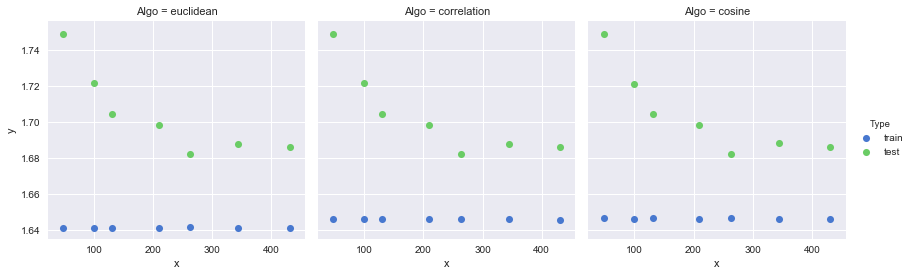

In [43]:
#RMSE as number of users increases
sns.lmplot(x="x", y="y", hue="Type", data=user_plot,col="Algo",
            ci=None, palette="muted",size=4,
           scatter_kws={"s": 50, "alpha": 1},fit_reg=False)

plt.show()

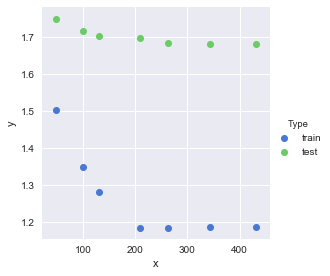

In [44]:
#RMSE as k increases for matrix factorization
sns.lmplot(x="x", y="y", hue="Type", data=model_plot,
            ci=None, palette="muted",size=4,
           scatter_kws={"s": 50, "alpha": 1},fit_reg=False,sharey=False)
plt.show()

# Conclusions

All of our models have outperformed our baseline, with the external library achieving the lowest RMSE. 
The downside of our work is that we severly restricted the number of items as required so it's difficult to say whether the models would generalize well for the rest of the catalogue. Smaller numbers of samples(users/items) achieve faster runtimes and accuracy but we have sacrificed coverage. This experiment uses .001% of the catalogue. In terms of the original objectives, we have definitely achieved a model that can make better predictions than a baseline for recommending books to clients. In terms of next steps. The native implementations could be slightly improved. For the User-based approach we could consider only the top k neighbours when predicting for an item instead of weighting every other user by their similarity. For the Model-based approach the native implementation would benefit from regularization to reduce overfitting and generalize better.  
The key take-aways are:
* As a proof of concept a collaborative filtering approach is superior to an averaged item/user rating baseline for recommending books to customers.
* The current implementation suffers from an inability to scale in terms of running time for large datasets.
* The current implementation achieves very poor coverage although this was a requirement.
* It's not clear how well the current implementation would generalize for a larger portion of the catalogue. Experiments not inlcuded here showed that increasing coverage to .95% resulted in the baseline outperforming all the models except the external library. 
* The entire model needs to be recalculated when new users or books are added.

# Final thoughts

There are a number of ways the current model can be tuned to fit with business needs.  
* For instance, adding a factor such that each predicted rating is scaled or boosted by some proportion based on a property of the book. As an example, a recency factor could weight recently published books more heavily. This would make newer books more likely to be recommended. Factors could also be based on price or current marketing initiatives. 